In [38]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import abtem
import ase
import dask
import os 
import sys

#paths
current_dir = os.getcwd()
parent_dir = os.path.abspath(os.path.join(current_dir, os.pardir))
data_dir = os.path.abspath(os.path.join(parent_dir, 'data', 'tests'))#choose path for results

#import homemade modules by adding hBN_sim directory to sys.path
sys.path.insert(0, parent_dir)
from helper_funcs import timeformat

In [2]:
#setting configuration
abtem.config.set({"device": "gpu", "fft": "fftw"})
dask.config.set({"num_workers": 1})

room for improvements:
- test and evaluate series on focal spread distribution more thoroughly (graphically)
  (see below -> Probe)
- research literature for value of sigma (frozen phonons) -> here reference value of 0.1 Å used (see abtem documentation)
- if possible and necessary: finetuning of parameters like semiangle_cutoff of aperture and spherical aberration (Cs)
- ...


### Parameters

In [3]:
# Parameters and Settings
vacancy_atom = 'B' # enter 'N' for replacement of N-atom, or 'B' for replacement of B-atom
defect_atom_symbol = 'O' # symbol of impurity atom(s)
defect_type = 'ring' #'single'/'double'/'ring' for calculating potential etc with single/double defect or ring structure
lattice_constant = 2.504 # lattice constant for hBN, https://www.sciencedirect.com/science/article/abs/pii/S0025540815300088
size_x = 20 #size of structure
size_y = 13

#probe #!
energy_probe = 60e3
defocus = 0 # 0 or f.e.: 'scherzer'
semiangle_cutoff = 30 # [mrad] maybe set to ctf crossover_angle, see below -> probe -> ctf? #!

#benchmark: Cs = -10e-6*1e10; astig = 10; coma = 1000; focal_spread = 10.0; angular_spread = 0.0
Cs = -10e-6*1e10 #spherical aberration; 10 micrometers
astig = 0 #25 aberration C12, ~few nanometers
astig_angle = 0 #+/-0.3 #rad
coma = 1500 #1000 aberration C21, ~few hundred nanometers
#focal_spread = 0.0
#angular_spread = 0.0

#------------------------------------------------------------------------------------------------------------------------------

#path
timestamp = timeformat()
path = (f'{timestamp}_hBN_size{size_x}x{size_y}_{defect_type}_vacany{vacancy_atom}_filledwith{defect_atom_symbol}_energy{int(energy_probe)}_defocus{defocus}_Cs{int(Cs)}_astig{astig}_astigangle{astig_angle}_coma{coma}')#_focal{int(focal_spread)}_ang{int(angular_spread)}')
print(path)

#variables total
variables_list = [timestamp, str(size_x) + 'x' + str(size_y), defect_type, vacancy_atom, defect_atom_symbol,
                 int(energy_probe), defocus, semiangle_cutoff, int(Cs), astig, astig_angle, coma]

20240922201047_hBN_size20x13_ring_vacanyB_filledwithO_energy60000_defocus0_Cs-100000_astig0_astigangle0_coma1500


In [6]:
#CREATION OF pd-DATAFRAME/csv for overview -> only first time needed

#df = pd.DataFrame({'timestamp': timestamp, 'size': str(size_x) + 'x' + str(size_y), 'defect_type': defect_type,
#                   'vacancy_atom': vacancy_atom, 'defect_atom_symbol': defect_atom_symbol, 'energy_probe': int(energy_probe),
#                   'defocus':defocus,'semiangle_cutoff': semiangle_cutoff,'Spherical_abberation_CS': int(Cs),'astigmastism': astig, 
#                   'astigangle': astig_angle,'coma': coma},index = [0])
#df.to_csv('{data_dir}/data_overview_test.csv', index=False)

# Atomic structure & Manipulation

#### Structure

In [6]:
#create hBN cell
hBN_cell = ase.build.graphene(formula='BN', a=lattice_constant, thickness=0.0, size=(1, 1, 1), vacuum=2)

#orthogonalize cell and create structure
hBN_orth = abtem.orthogonalize_cell(hBN_cell)
hBN = hBN_orth*(size_x, size_y, 1) #!

#### Center Atoms

In [7]:
#find atoms located in the center
x_center = max(hBN.positions[:, 0])/2
y_center = max(hBN.positions[:, 1])/2

mask_center_position_x = ((hBN.positions[:,0] < x_center + lattice_constant)*
                          (hBN.positions[:,0] > x_center - lattice_constant))
mask_center_position_y = ((hBN.positions[:,1] < y_center + lattice_constant)*
                          (hBN.positions[:,1] > y_center - lattice_constant))
mask_center = mask_center_position_x * mask_center_position_y

center_indices = (np.asarray(np.where(mask_center == True)))[0]
center_indices.shape

(8,)

#### Assignments: Positions for Single and Double Defects, Ring Structure

In [8]:
#SINGLE: find index values in the middle of center index array to adress one (or two) specific atom(s)
ind = int(len(center_indices)/2 - 1) #center_indices.shape = (1,8);
ind_random = center_indices[ind]

#check if chosen atom is wanted single defect type and/or (re-)assign
if hBN.symbols[ind_random] == vacancy_atom:
    ind_single = ind_random
else:
    ind_single = center_indices[ind + 2]
    # +2 because Atoms are saved in the structure [... N N B B N N B...]

#for DOUBLE: make sure, the two atoms are neighbours
#find distance of next neighbours
nnd = round(hBN.get_distance(1, 3),4)

for index in center_indices:
    index_dist = round(hBN.get_distance(ind_single, index),4)
    if index_dist == nnd:
        #found next neighbour -> assign second index
        ind_double = [ind_single, index]
        break
    else:
        pass

#for RING:
#find distances of second neighbours (nnd_2) and third neighbors (nnd_3)
nnd_2 = round(hBN.get_distance(1, 2),4)
nnd_3 = round(hBN.get_distance(0,2),4)#dist for atoms opposed to each other

for startindex in center_indices:
    #create dummy array for ring indices and assign first two possitions with double indices
    ind_ring = [0 for i in range(6)]
    ind_ring[0] = startindex

    #find atom opposite to first atom
    for index in center_indices:
        dist_to_1 = round(hBN.get_distance(ind_ring[0], index),4)
        if dist_to_1 == nnd_3:
            ind_ring[3] = index #position 4
            break
        else:
            pass

    #find next neighbour to first atom
    for index in center_indices:
        dist_to_1 = round(hBN.get_distance(ind_ring[0], index),4)
        dist_to_4 = round(hBN.get_distance(ind_ring[3], index),4)
        if dist_to_1 == nnd and dist_to_4 == nnd_2:
            ind_ring[1] = index #position 2
            dist_to_2 = round(hBN.get_distance(ind_ring[1], index),4)

        else:
            pass
    
    
    #find remaining atoms (position numbering 1 to 6): 
    for index in center_indices:
        dist_to_1 = round(hBN.get_distance(ind_ring[0], index),4)
        dist_to_2 = round(hBN.get_distance(ind_ring[1], index),4)
        dist_to_4 = round(hBN.get_distance(ind_ring[3], index),4)
        if dist_to_1 == nnd_2 and dist_to_2 == nnd and dist_to_4 == nnd:
            ind_ring[2] = index #position 3 
        if dist_to_1 == nnd_2 and dist_to_2 == nnd_3 and dist_to_4 == nnd:
            ind_ring[4] = index #position 5
        if dist_to_1 == nnd and dist_to_2 == nnd_2 and dist_to_4 == nnd_2:
            ind_ring[5] = index #position 6 
    else:
        pass

    #check positions are left with zeroes:
    if np.any([element==0 for element in ind_ring]):
        pass
    else:
        break

print(f'Center indices: {center_indices}')
print(f'Chosen index single: {ind_single}')
print(f'Chosen index double: {ind_double}')
print(f'Chosen index ring: {ind_ring}')

Center indices: [492 493 494 495 544 545 546 547]
Chosen index single: 495
Chosen index double: [495, 493]
Chosen index ring: [493, 544, 545, 547, 546, 495]


#### Impurities

In [9]:
#insert impurity atoms - introducing single and double defects
hBN_single = hBN.copy()
hBN_double = hBN.copy()
hBN_ring = hBN.copy()

hBN_single.symbols[ind_single] = defect_atom_symbol
hBN_double.symbols[ind_double] = defect_atom_symbol
hBN_ring.symbols[ind_ring] = defect_atom_symbol

(<Figure size 640x480 with 1 Axes>, <Axes: xlabel='x [Å]', ylabel='y [Å]'>)

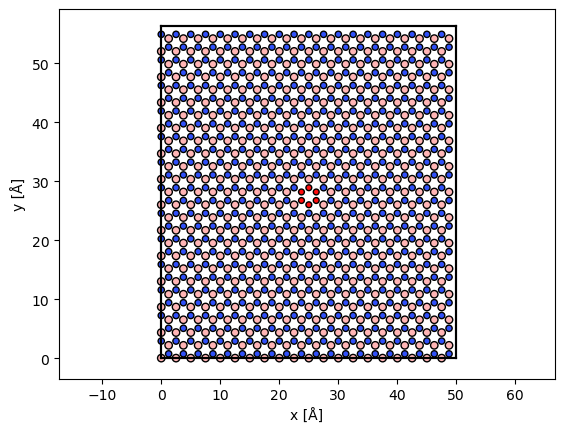

In [10]:
#show
#abtem.show_atoms(hBN_center, numbering=True, merge=False)
#hBN_ring.symbols[ind_ring] = 'O'
#hBN_ring.symbols[center_indices] = 'S'
#hBN_ring.symbols[ind_double] = 'C'
abtem.show_atoms(hBN_ring)

# Potential

In [16]:
#RUN BEFORE CALCULATING POTENTIAL
if defect_type == 'double':
    hBN_manipulated = hBN_double
elif defect_type == 'single':
    hBN_manipulated = hBN_single
elif defect_type == 'ring':
    hBN_manipulated = hBN_ring
else:
    raise KeyboardInterrupt

hBN_manipulated

Atoms(symbols='B517N517O6', pbc=[True, True, False], cell=[50.08, 56.38171788798209, 4.0])

In [17]:
#implement frozen phonons (average of random offset-snapshots)
frozen_phonons = abtem.FrozenPhonons(hBN_manipulated, num_configs=10, sigmas=0.1) #! num_configs -> echte sim: 20

In [18]:
#create potential (sampling = physical extent/ gridpoints), slice thickness not usefull - no layers
potential = abtem.Potential(frozen_phonons, sampling=0.05)
potential.shape

(10, 4, 1002, 1128)

# Probe

### Partial spacial & temporal coherence

In [19]:
#consider partial temporal coherence (due to energy spread of probe) by building gaussian distributed defocus series

#focal_spread = focal_spread
#defocus_distribution = abtem.distributions.gaussian(center=0.0, standard_deviation=focal_spread, num_samples=11,
#                                                    sampling_limit=2, ensemble_mean=False,)
#condider partial spacial coherence (due to source size)
#angular_spread = angular_spread

#create probe and insert parameters for abberations (ctf)
#aberration_coefficients = {'C10': defocus_distribution, 'C30': Cs, 'C12': astig, 'C21': coma}

aberration_coefficients = {'C10': defocus, 'C30': Cs, 'C12': astig, 'C21': coma}

_Note:_
- partial spacial coherence: will be considered by using gaussian filter during postprocessing
- partial temporal coherence: would be described even more accurately by using distribution of defocus vaules(see above). Due to high computational cost and negligible differences compared to single defocus value, only one fixed value is being considered.

### probe building

In [20]:
probe = abtem.Probe(energy=energy_probe, semiangle_cutoff=semiangle_cutoff, aberrations=aberration_coefficients, astigmatism_angle=astig_angle) #maybe use crossover angle of ctf for semiangle_cutoff? #!
probe.grid.match(potential)
probe.sampling

(0.04998003992015968, 0.04998379245388483)

In [21]:
probe.build().compute()

[########################################] | 100% Completed | 908.53 ms


# Scan & Detect

In [22]:
#choose Nyquist sampling for scan
sampling = probe.aperture.nyquist_sampling
print(f'Nyquist sampling: {sampling:.3f} Å/pixel')

Nyquist sampling: 0.406 Å/pixel


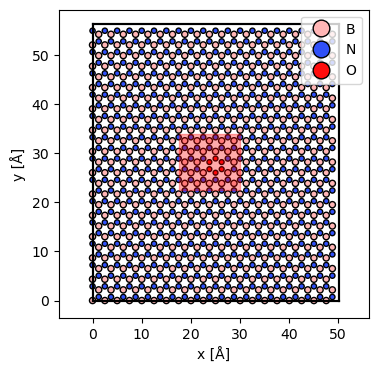

In [28]:
#setup for grid scan
gridscan = abtem.GridScan(start=[3.5/10, 4/10], end=[6/10, 6/10], fractional = True,
                     potential=potential, sampling=sampling) 
#gridscan = abtem.GridScan(start=[0, 0], end=[10/10, 10/10], fractional = True,
#                     potential=potential, sampling=sampling) #!

fig, ax = abtem.show_atoms(hBN_manipulated, figsize=(4,4), legend=True)
gridscan.add_to_plot(ax)

In [29]:
#setup detector
detector_maadf = abtem.AnnularDetector(inner=60, outer=200)

In [30]:
#apply scan & detectors
measurements_total = probe.scan(potential, scan=gridscan, detectors=detector_maadf)

# Export & Import

In [40]:
#compute and EXPORT... 
measurements_total.to_zarr(f'{data_dir}/{path}_RAW.zarr')

#and/or IMPORT from file
imported_measurements = abtem.from_zarr(f'{data_dir}/{path}_RAW.zarr')
#imported_measurements = abtem.from_zarr(f'{data_dir}/{path_old}_RAW.zarr')#for multiple versions
#imported_measurements = abtem.from_zarr(f'INSERTPATH.zarr')

In [46]:
#add to overview dataframe by appending new row with df.loc[index]
df = pd.read_csv(f'{data_dir}/data_overview_tests.csv')
df.loc[len(df.index)] = [value for value in variables_list]
df.to_csv(f'{data_dir}/data_overview_tests.csv', index=False)
df.tail()

#df.drop(index=1); df.drop(df.columns[0], axis=1) -> delete entry/column; 
#df.iloc[index_row, index_col] -> adress row/col, df.iat[.,.] -> adress single item

,timestamp,size,defect_type,vacancy_atom,defect_atom_symbol,energy_probe,defocus,semiangle_cutoff,Spherical_abberation_CS,astigmastism,astigangle,coma
40,20240922193702,20x13,single,N,C,60000,0,30,-100000,25,0.0,1500
41,20240922194612,20x13,ring,B,C,60000,3,30,-100000,0,0.0,0
42,20240922194613,20x13,ring,B,C,60000,6,30,-100000,0,0.0,0
43,20240922201047,20x13,ring,B,O,60000,0,30,-100000,0,0.0,1500
44,20240922201047,20x13,ring,B,O,60000,0,30,-100000,0,0.0,1500


# Postprocessing

In [47]:
#set parameters for postprocessing
#pairs: interpolate:0.01 & gauss: 0.2;  interpolate:0.05 & gauss: 0.3
#interpolate-> higher value (0.1) more pixels; low value -> smoother, more time
interpolate = 0.01
gauss = 0.3
dose = 1e9


path_final = (f'{path}_interpol{interpolate}_gauss{gauss}_dose{int(dose)}')
#path_final = (f'{path_old}_interpol{interpolate}_gauss{gauss}_dose{dose}') #-> for multiple postprocessing versions
print(path_final)

20240922201047_hBN_size20x13_ring_vacanyB_filledwithO_energy60000_defocus0_Cs-100000_astig0_astigangle0_coma1500_interpol0.01_gauss0.3_dose1000000000


[########################################] | 100% Completed | 108.12 ms


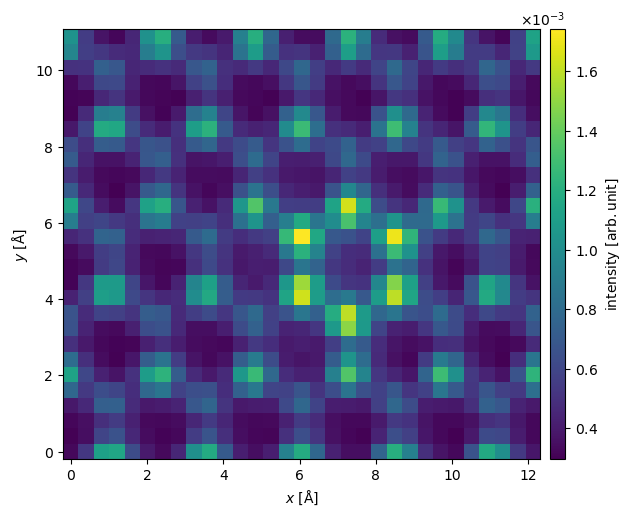

In [48]:
#assign detectors
maadf_measurement = imported_measurements# integrate_radial(60, 200)

#..and plot
measurements = maadf_measurement
measurements.show(figsize=(14, 5), cbar=True,);

[########################################] | 100% Completed | 2.22 sms


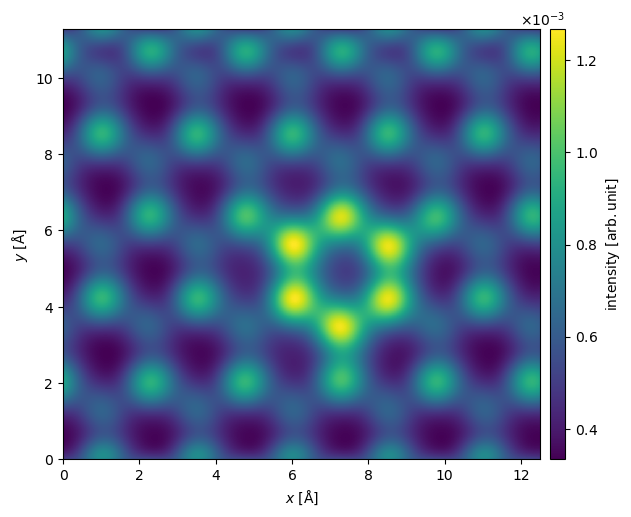

In [49]:
#interpolate to smooth images and apply gaussian filter to consider partial spatial coherence 
final_measurements = measurements.interpolate(interpolate).gaussian_filter(gauss)

#plot
final_measurements.show(explode=True, figsize=(14, 5), cbar=True)

[########################################] | 100% Completed | 813.43 ms


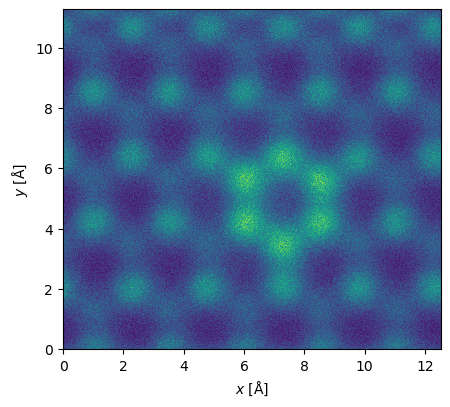

In [50]:
#noise to account for finite electrone dose -> statistic deviation (see abtem walkthrough -> scan & detect)

noisy_measurements = final_measurements.poisson_noise(dose_per_area=dose, seed=100)
noisy_measurements.show(explode=True, figsize=(12, 4))

#zoom in
#plt.xlim(0,2)
#plt.ylim(0,2)

In [51]:
#export
noisy_measurements.to_zarr(f'{data_dir}/{path_final}_FINAL.zarr')
#noisy_measurements.to_zarr(f'{data_dir}/{path_final_old}_FINAL2.zarr')

[########################################] | 100% Completed | 812.38 ms


[[None]]

[########################################] | 100% Completed | 103.11 ms


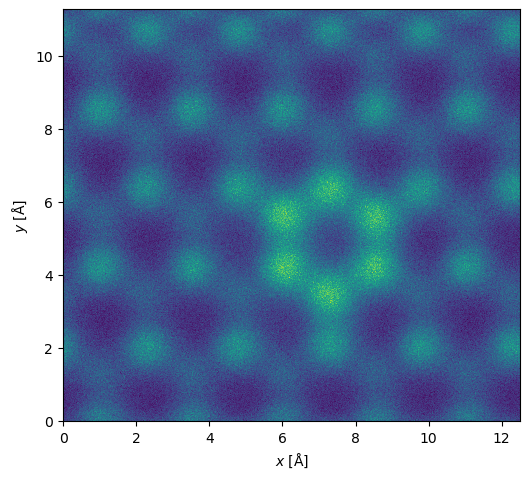

In [53]:
import_new = abtem.from_zarr(f'{data_dir}/{path_final}_FINAL.zarr')
import_new.show(explode=True)

In [54]:
#reassign path variable to avoid overwriting
path_old = path
path_final_old = path_final
#create new path variable
timestamp = timeformat()
path = (f'{timestamp}_hBN_size{size_x}x{size_y}_{defect_type}_vacany{vacancy_atom}_filledwith{defect_atom_symbol}_energy{int(energy_probe)}_defocus{defocus}_Cs{int(Cs)}_astig{astig}_astigangle{astig_angle}_coma{coma}')#_focal{int(focal_spread)}_ang{int(angular_spread)}')
path_final = (f'{path}_interpol{interpolate}_gauss{gauss}_dose{dose}')

print(path_old)
print(path)

20240922201047_hBN_size20x13_ring_vacanyB_filledwithO_energy60000_defocus0_Cs-100000_astig0_astigangle0_coma1500
20240922204052_hBN_size20x13_ring_vacanyB_filledwithO_energy60000_defocus0_Cs-100000_astig0_astigangle0_coma1500
